In [1]:
import os
import warnings
import math
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from sklearn.metrics import mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.metrics import recall_score, classification_report, precision_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize
from scipy import ndimage
import seaborn as sns

In [3]:
test_data = pd.read_csv('/Users/iammhaiderkhan/Desktop/Documents/Study stuff/MASS Semester 2/Computational Astrobiology/archive/exoTest.csv').fillna(0)
train_data = pd.read_csv('/Users/iammhaiderkhan/Desktop/Documents/Study stuff/MASS Semester 2/Computational Astrobiology/archive/exoTrain.csv').fillna(0)

In [4]:
categ = {2: 1,1: 0}
train_data.LABEL = [categ[item] for item in train_data.LABEL]
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [5]:
#Reduce memory
def reduce_memory(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
test_data = reduce_memory(test_data)
train_data = reduce_memory(train_data)

Memory usage of dataframe is 13.91 MB
Memory usage after optimization is: 6.25 MB
Decreased by 55.1%
Memory usage of dataframe is 124.12 MB
Memory usage after optimization is: 62.04 MB
Decreased by 50.0%


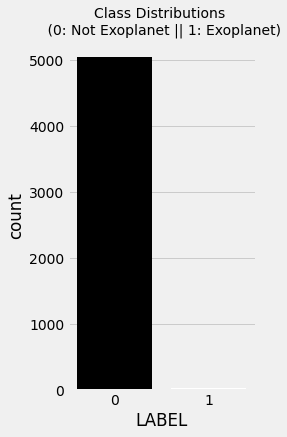

In [7]:
#Visualization:
plt.figure(figsize=(3,6))
colors = ["0", "1"]
sns.countplot('LABEL', data=train_data, palette=colors)
plt.title('Class Distributions \n (0: Not Exoplanet || 1: Exoplanet)', fontsize=14)
print()

In [8]:
type(test_data)

pandas.core.frame.DataFrame

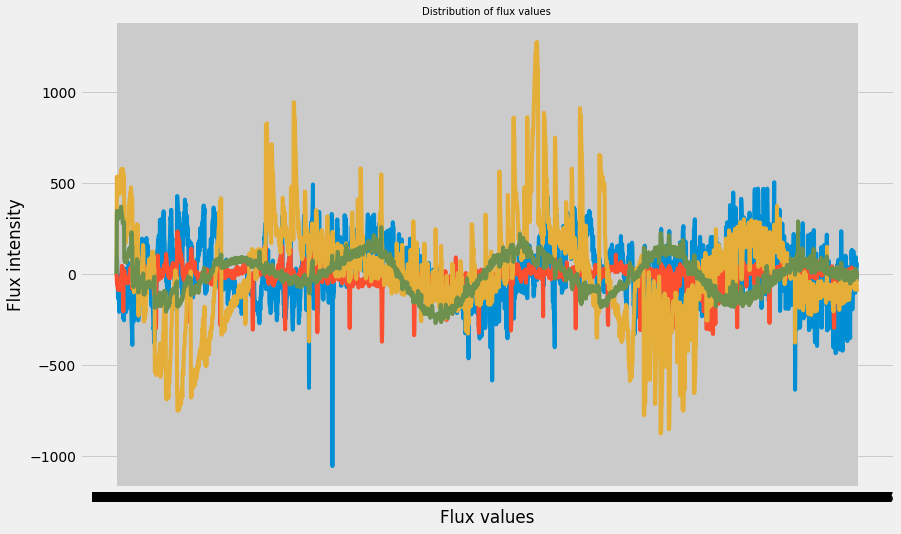

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(train_data.iloc[0,])
plt.plot(train_data.iloc[1,])
plt.plot(train_data.iloc[2,])
plt.plot(train_data.iloc[3,])

plt.show()

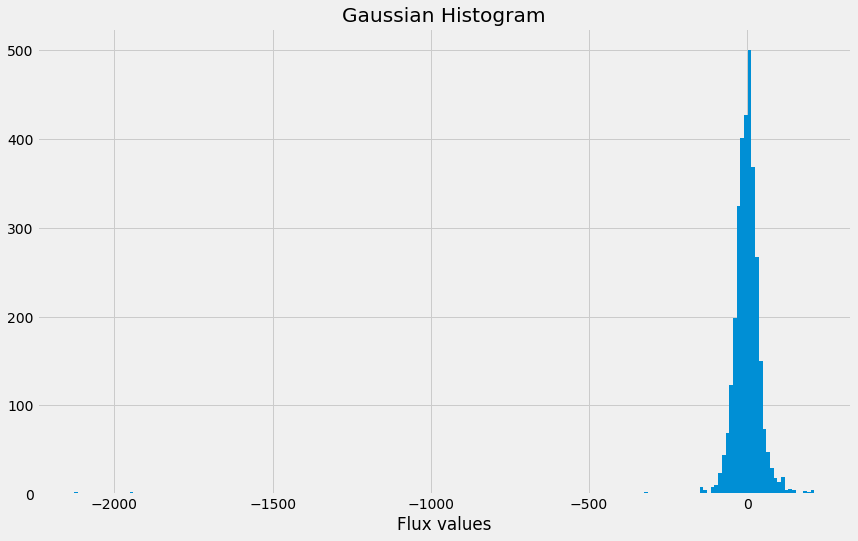

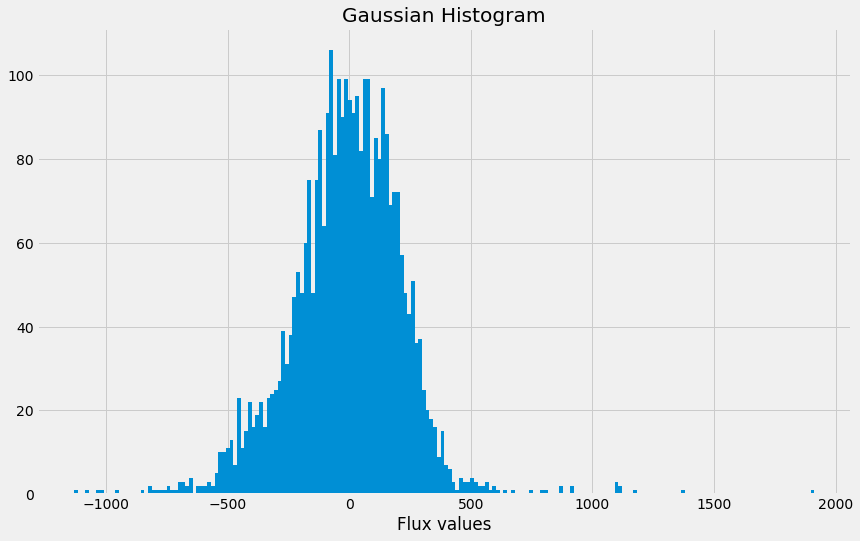

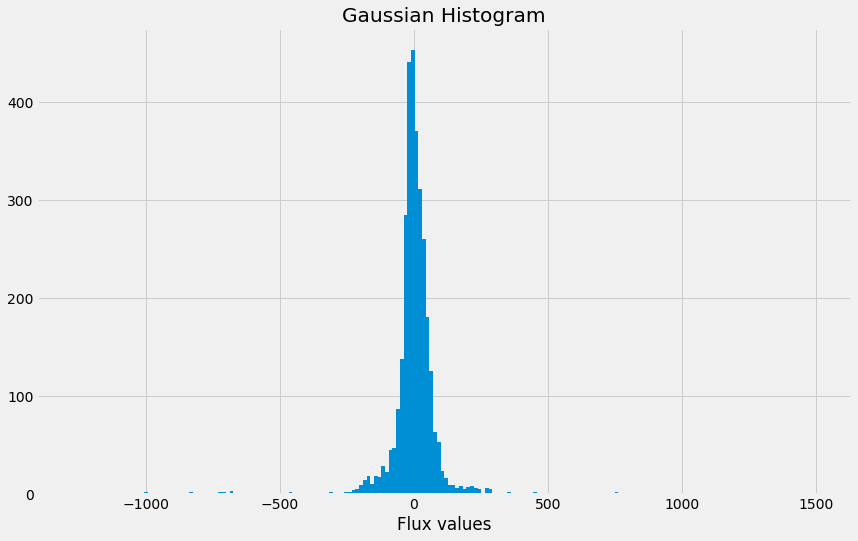

In [10]:
#Gaussian histogram of no exoplanets
labels_1=[100,200,300]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

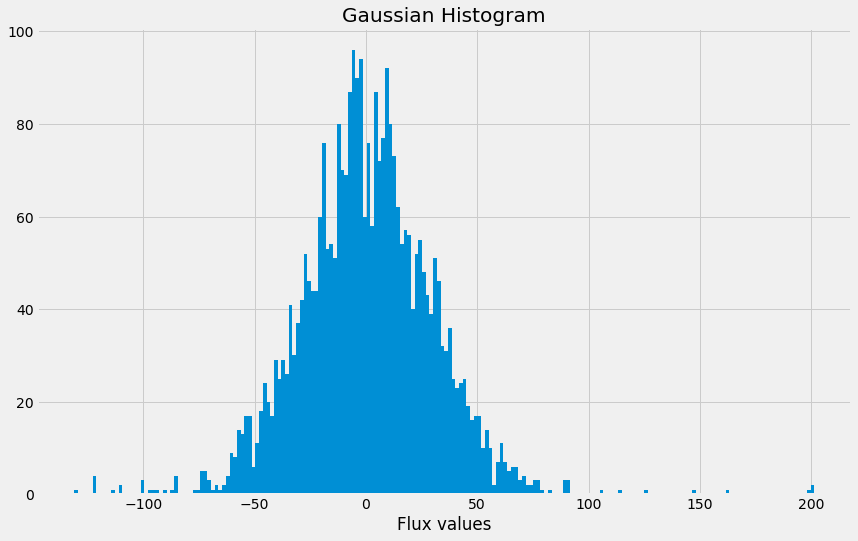

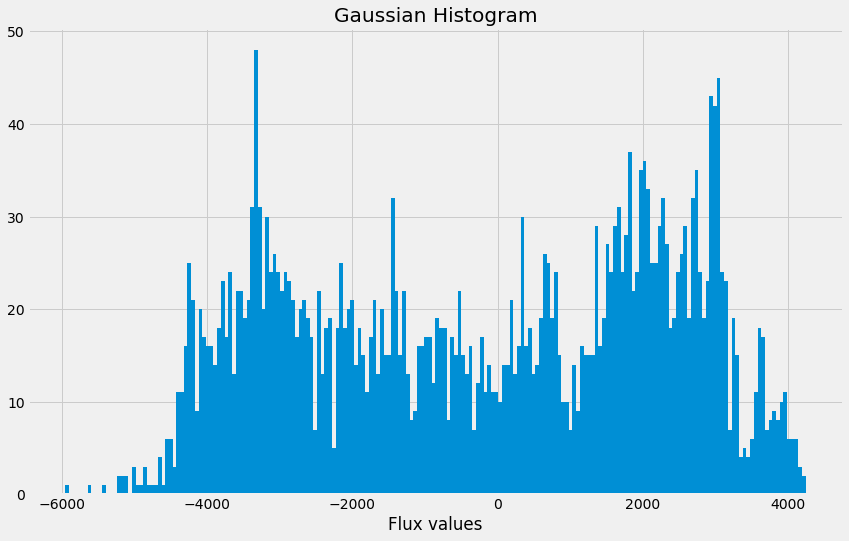

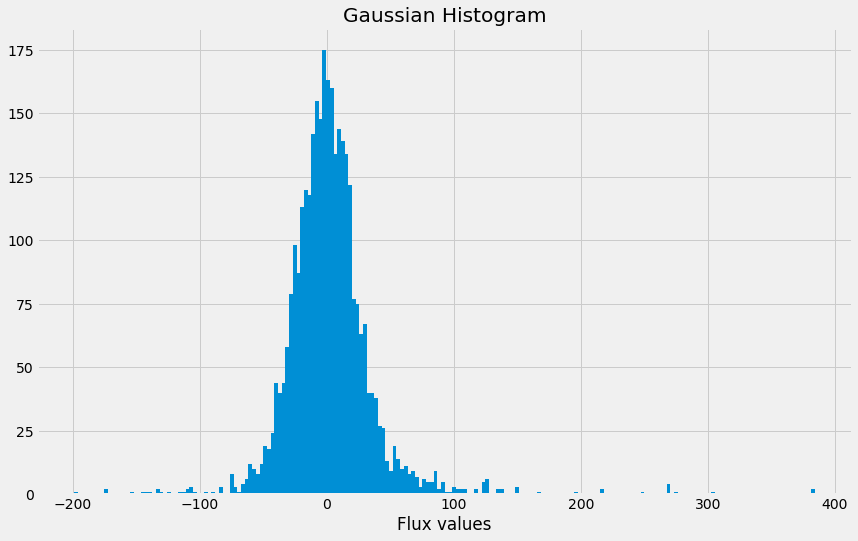

In [11]:
#Gaussian histogram of exoplanets
labels_1=[16,21,25]
for i in labels_1:
    plt.hist(train_data.iloc[i,:], bins=200)
    plt.title("Gaussian Histogram")
    plt.xlabel("Flux values")
    plt.show()

In [12]:
#splitting the data
x_train = train_data.drop(["LABEL"],axis=1)
y_train = train_data["LABEL"]   
x_test = test_data.drop(["LABEL"],axis=1)
y_test = test_data["LABEL"]

In [13]:
#Normalizing the data
x_train = normalized = normalize(x_train)
x_test = normalize(x_test)

#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

In [14]:
#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)


In [15]:
x_train

array([[ 0.15685749,  0.15709266,  0.15753295, ..., -0.54823685,
        -0.53487396, -0.5281412 ],
       [ 0.14612748,  0.1463192 ,  0.14667368, ..., -0.54421026,
        -0.53083116, -0.5240899 ],
       [ 0.12514697,  0.1252505 ,  0.12543076, ..., -0.53638697,
        -0.5229764 , -0.5162188 ],
       ...,
       [ 2.0637712 ,  2.0617208 ,  2.0576317 , ..., -1.273148  ,
        -1.2798492 , -1.2832644 ],
       [ 2.1128154 ,  2.110763  ,  2.1066673 , ..., -1.2389443 ,
        -1.2455249 , -1.2488793 ],
       [ 2.137636  ,  2.1355817 ,  2.1314816 , ..., -1.2216945 ,
        -1.2282134 , -1.2315366 ]], dtype=float32)

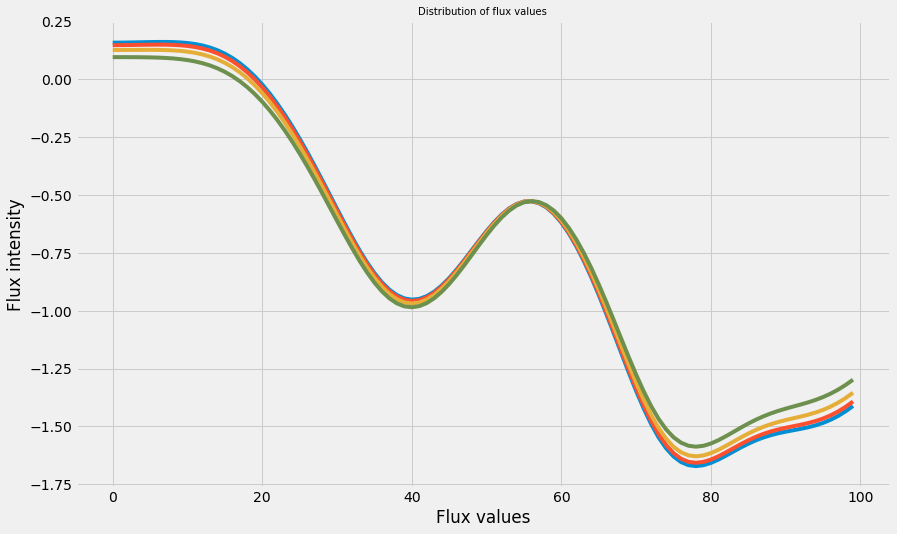

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8
plt.title('Distribution of flux values', fontsize=10)
plt.xlabel('Flux values')
plt.ylabel('Flux intensity')
plt.plot(x_train[0,0:100])
plt.plot(x_train[1,0:100])
plt.plot(x_train[2,0:100])
plt.plot(x_train[3,0:100])

plt.show()

In [17]:
#Dimentioanlity reduction
from sklearn.decomposition import PCA
pca = PCA() 
X_train = pca.fit_transform(x_train)
X_test = pca.transform(x_test)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1

In [18]:
type(X_train)

numpy.ndarray

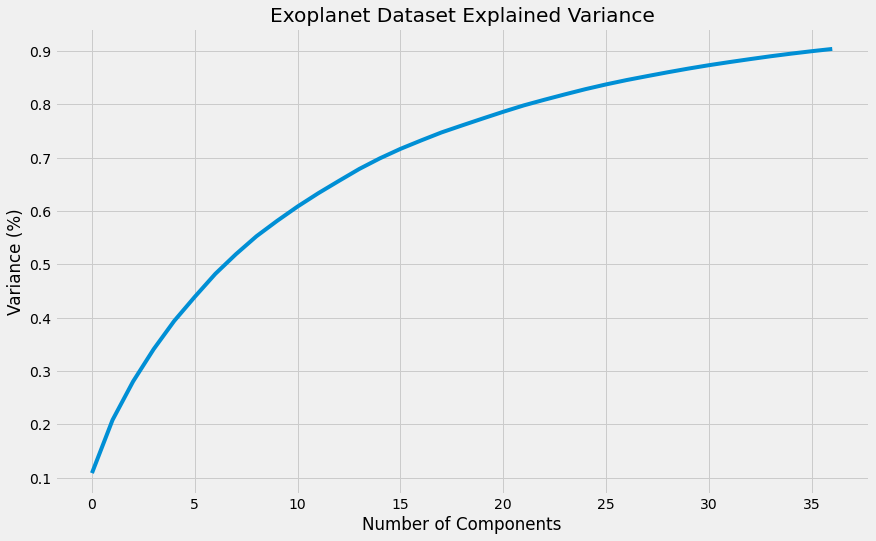

RangeIndex(start=0, stop=37, step=1)

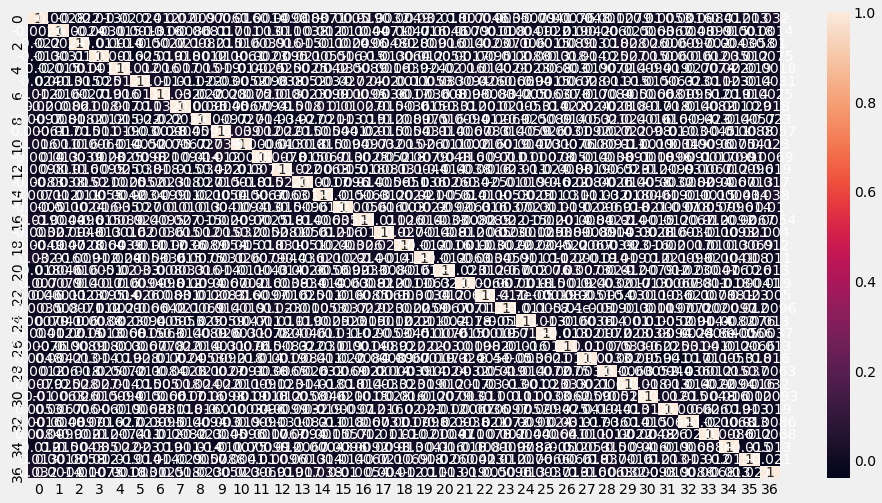

In [18]:
#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()
        
df = pd.DataFrame.from_records(x_train)     
corr = df.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)
df.columns

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
sm = SMOTE(random_state=27, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 37
Before OverSampling, counts of label '0': 5050 

After OverSampling, counts of label '1': 5050
After OverSampling, counts of label '0': 5050


Creating a Model

In [21]:
def model(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    #fit the model
    classifier.fit(dtrain_x,dtrain_y)
    predictions = classifier.predict(dtest_x)

    #Cross validation
    accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 5, n_jobs = -1)
    mean = accuracies.mean()
    variance = accuracies.std()
    print("Accuracy mean: "+ str(mean))
    print("Accuracy variance: "+ str(variance))

    #Accuracy
    print ("\naccuracy_score :",accuracy_score(dtest_y,predictions))

    #Classification report
    print ("\nclassification report :\n",(classification_report(dtest_y,predictions)))

    #Confusion matrix
    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,predictions),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

Accuracy mean: 0.9991089108910891
Accuracy variance: 0.0017821782178217838

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



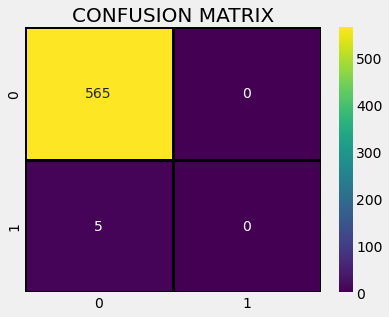

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
SVM_model=SVC()
model(SVM_model,x_train_res,y_train_res,x_test,y_test)

In [23]:
import numpy as np

def add_noise(flux, noise_level=0.01):
    """Add random Gaussian noise to the flux data."""
    noise = np.random.normal(0, noise_level, flux.shape)
    return flux + noise

def shift_flux(flux, shift_max=5):
    """Shift the flux data by a random number of steps."""
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(flux, shift)

def scale_flux(flux, scale_range=(0.9, 1.1)):
    """Scale the flux data by a random factor within the given range."""
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return flux * scale_factor

In [31]:

def augment_data(flux_data):
    """Apply specified augmentations to the flux data."""
    augmented_data = []
    for flux in flux_data:
        augmented_data.append(flux)
        augmented_data.append(add_noise(flux))
        augmented_data.append(shift_flux(flux))
        augmented_data.append(scale_flux(flux))
    return np.array(augmented_data)

In [32]:
train_flux = train_data.drop(columns=['LABEL']).values
train_labels = train_data['LABEL'].values

# Augment the training data
augmented_flux = augment_data(train_flux)
augmented_labels = np.repeat(train_labels, 4)  # Original data + 3 augmentations

# Recreate the training dataframe with augmented data
augmented_train_data = pd.DataFrame(augmented_flux)
augmented_train_data['LABEL'] = augmented_labels 

print("Original data shape:", train_data.shape)
print("Augmented data shape:", augmented_train_data.shape)

Original data shape: (5087, 3198)
Augmented data shape: (20348, 3198)


In [33]:
#Normalizing the data
x_train = normalize(augmented_train_data.drop(columns=['LABEL']).values)
x_test = normalize(test_data.drop(columns=['LABEL']).values)
y_train = augmented_train_data['LABEL'].values
y_test = test_data['LABEL'].values

#Applying of gaussian filter
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)
x_test = ndimage.filters.gaussian_filter(x_test, sigma=10)

#Feature scaling
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)
x_test = std_scaler.fit_transform(x_test)

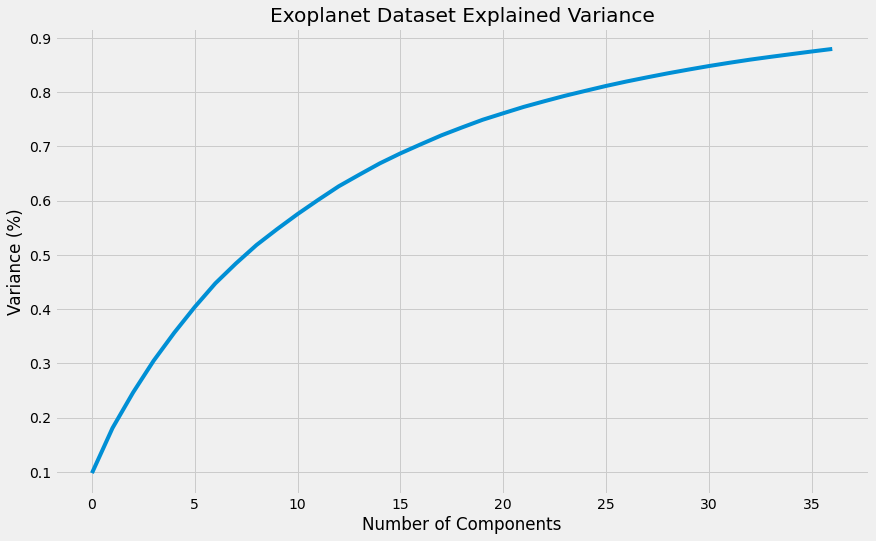

In [34]:
#Apply PCA with n_componenets
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

In [35]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))
sm = SMOTE(random_state=27, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train.ravel())
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 148
Before OverSampling, counts of label '0': 20200 

After OverSampling, counts of label '1': 20200
After OverSampling, counts of label '0': 20200


Accuracy mean: 0.9995297029702972
Accuracy variance: 0.0005773219697866516

accuracy_score : 0.9912280701754386

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       0.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       0.50      0.50      0.50       570
weighted avg       0.98      0.99      0.99       570



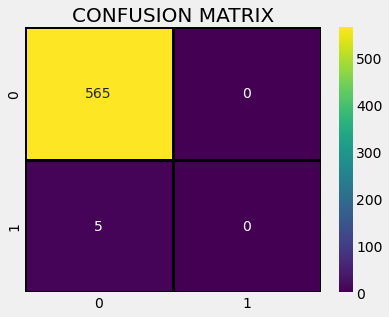

In [36]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
SVM_model=SVC()
model(SVM_model,x_train_res,y_train_res,x_test,y_test)